# SARIMAXによる株価予測（日本製鉄）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
data = pd.read_csv('./5401_jp_m.csv', index_col='Date', parse_dates=True)
data.drop('Volume', axis=1, inplace=True)
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)
data

,Open,High,Low,Close
2018-01-31,2528.78,2688.43,2384.58,2385.00
2018-02-28,2420.20,2453.23,2156.67,2194.44
2018-03-31,2163.11,2177.27,1912.46,2031.87
2018-04-30,2033.19,2138.84,1975.35,2074.05
2018-05-31,2051.87,2197.52,1970.56,1984.91
...,...,...,...,...
2022-09-30,2194.08,2240.01,1991.50,2006.50
2022-10-31,1994.50,2154.00,1960.50,2042.50
2022-11-30,2063.50,2299.50,2056.50,2192.50
2022-12-31,2187.00,2336.00,2161.50,2292.00


In [3]:
data.tail(20)

,Open,High,Low,Close
2021-06-30,1876.09,1911.24,1603.12,1710.40
2021-07-31,1735.49,1757.40,1588.51,1727.28
2021-08-31,1755.13,2060.96,1714.96,2052.28
2021-09-30,2051.37,2173.71,1831.81,1906.36
2021-10-31,1876.37,1952.29,1752.65,1873.55
2021-11-30,1915.73,1986.96,1589.57,1592.85
2021-12-31,1588.63,1807.02,1584.42,1760.62
2022-01-31,1776.56,2121.00,1674.86,1739.07
2022-02-28,1734.38,1986.50,1704.86,1976.19
2022-03-31,2015.08,2173.01,1839.82,2099.32


## データの可視化

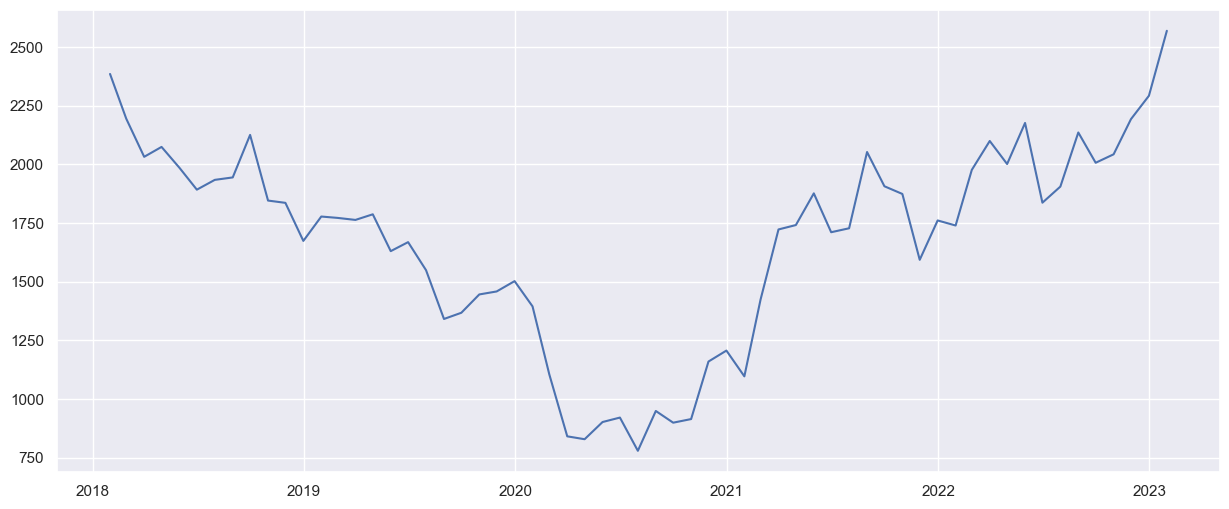

In [4]:
plt.plot(data['Close'])
plt.show()

## 自己相関係数・偏自己相関係数

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


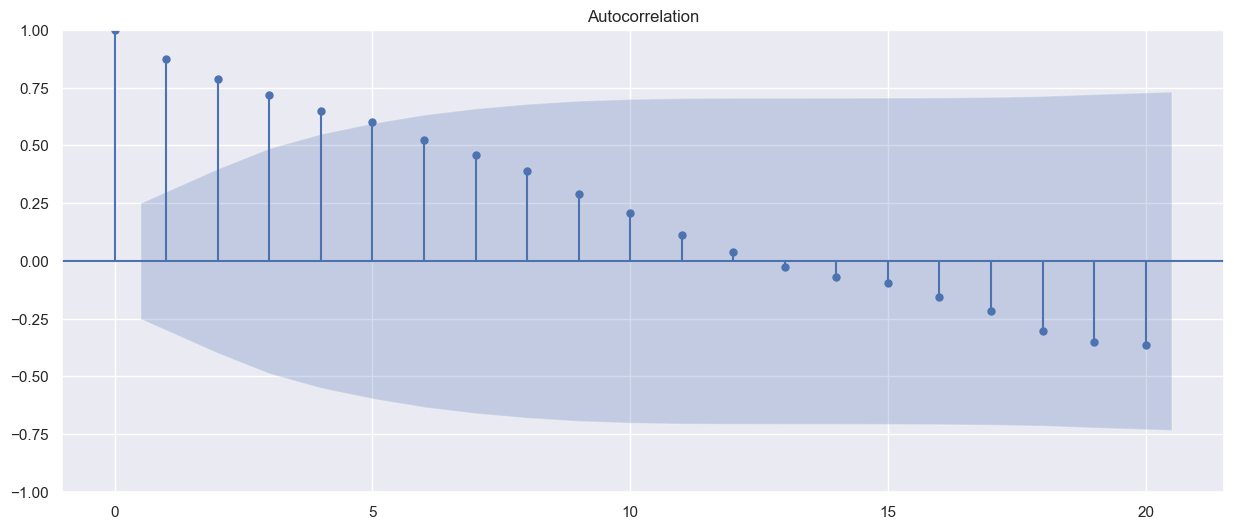

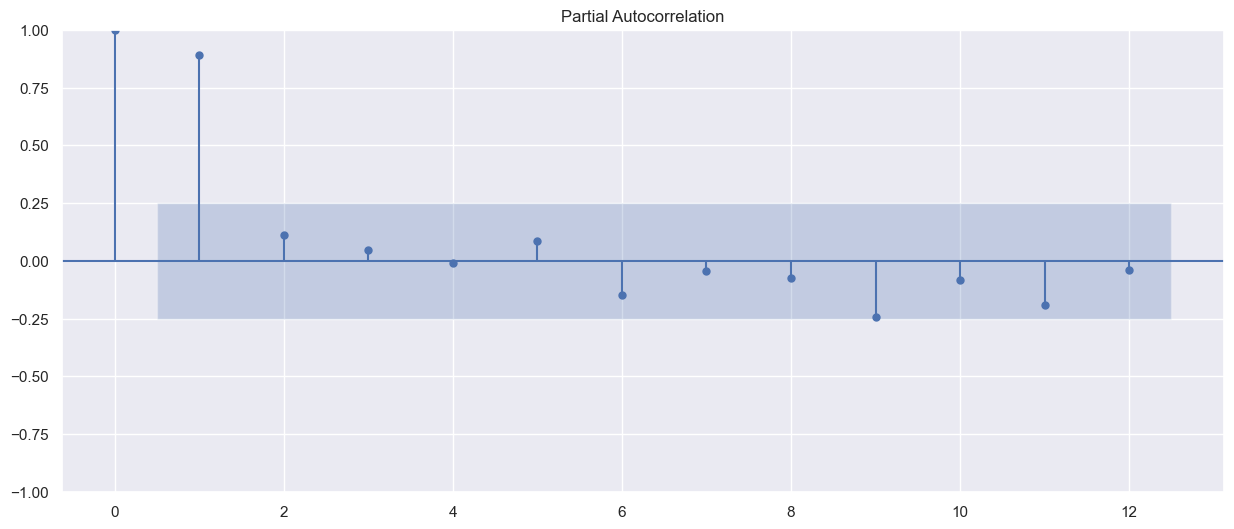

In [5]:
fig_1 = sm.graphics.tsa.plot_acf(data['Close'], lags=20)
fig_2 = sm.graphics.tsa.plot_pacf(data['Close'], lags=12)

## 波状分解

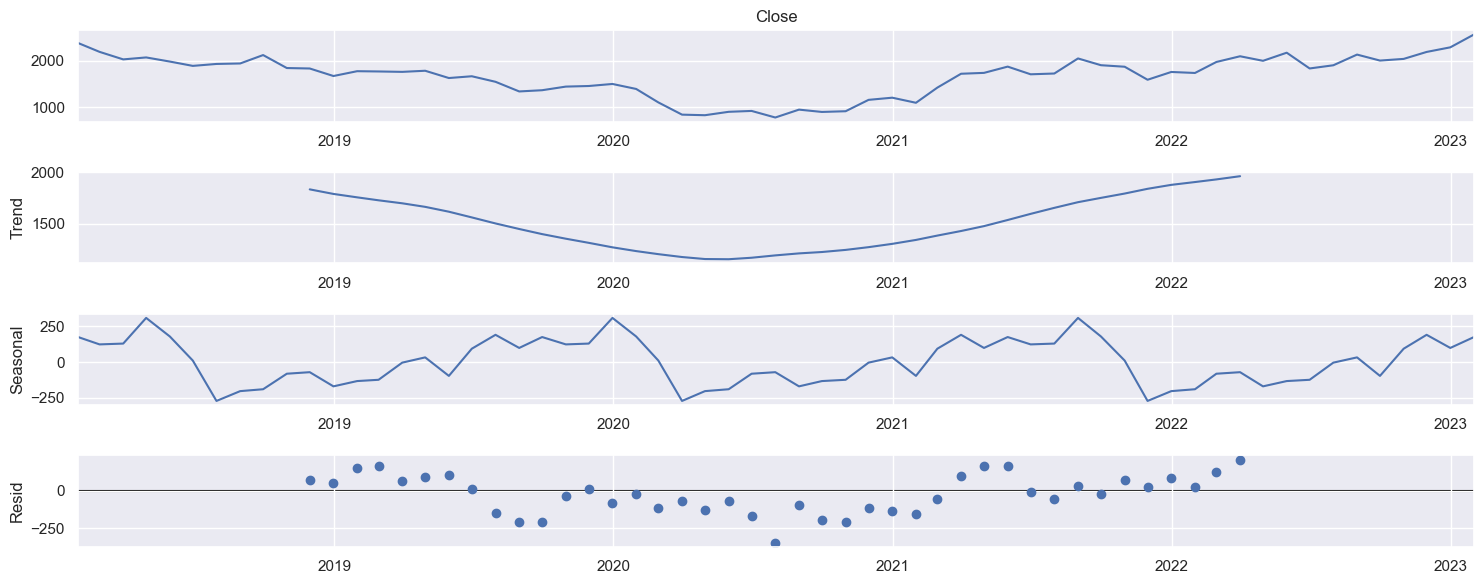

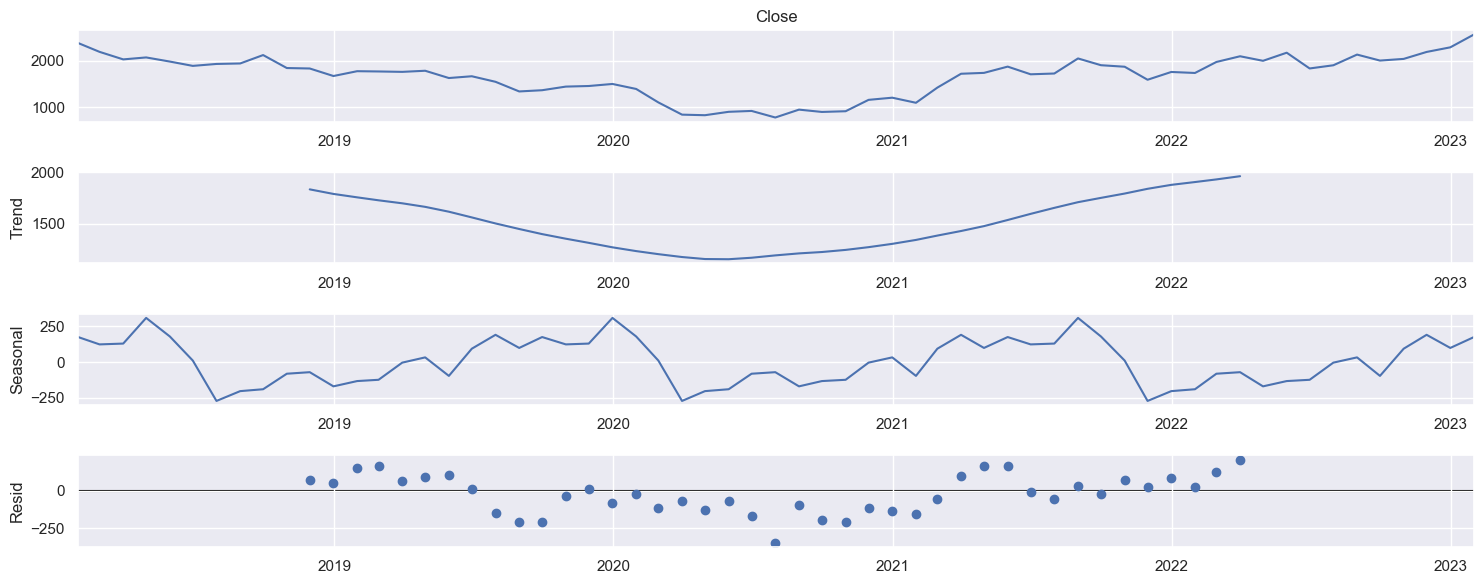

In [6]:
result = seasonal_decompose(data['Close'], period=20, two_sided=True)
result.plot()

## 単位根検定

In [7]:
print('-----------原系列-----------')
nc = sm.tsa.stattools.adfuller(data['Close'], regression='n')
c = sm.tsa.stattools.adfuller(data['Close'], regression='c')
ct = sm.tsa.stattools.adfuller(data['Close'], regression='ct')
ctt = sm.tsa.stattools.adfuller(data['Close'], regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

print()
print('--------一次階差系列---------')
data_diff = data['Close'].diff().dropna()

nc = sm.tsa.stattools.adfuller(data_diff, regression='nc')
c = sm.tsa.stattools.adfuller(data_diff, regression='c')
ct = sm.tsa.stattools.adfuller(data_diff, regression='ct')
ctt = sm.tsa.stattools.adfuller(data_diff, regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

-----------原系列-----------
nc p-value:0.63533400890407
c p-value:0.6849743456176819
ct p-value:0.8700356896798325
ctt p-value:0.5407088545941198

--------一次階差系列---------
nc p-value:1.4071314766037822e-12
c p-value:1.7133990963177725e-11
ct p-value:2.0260674902015847e-11
ctt p-value:1.4644902401733856e-10


c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


原系列はやはり単位根が存在している。\
一方一次の階差をとった系列はp値が小さいため、共分散定常性を持つことを仮定できる。

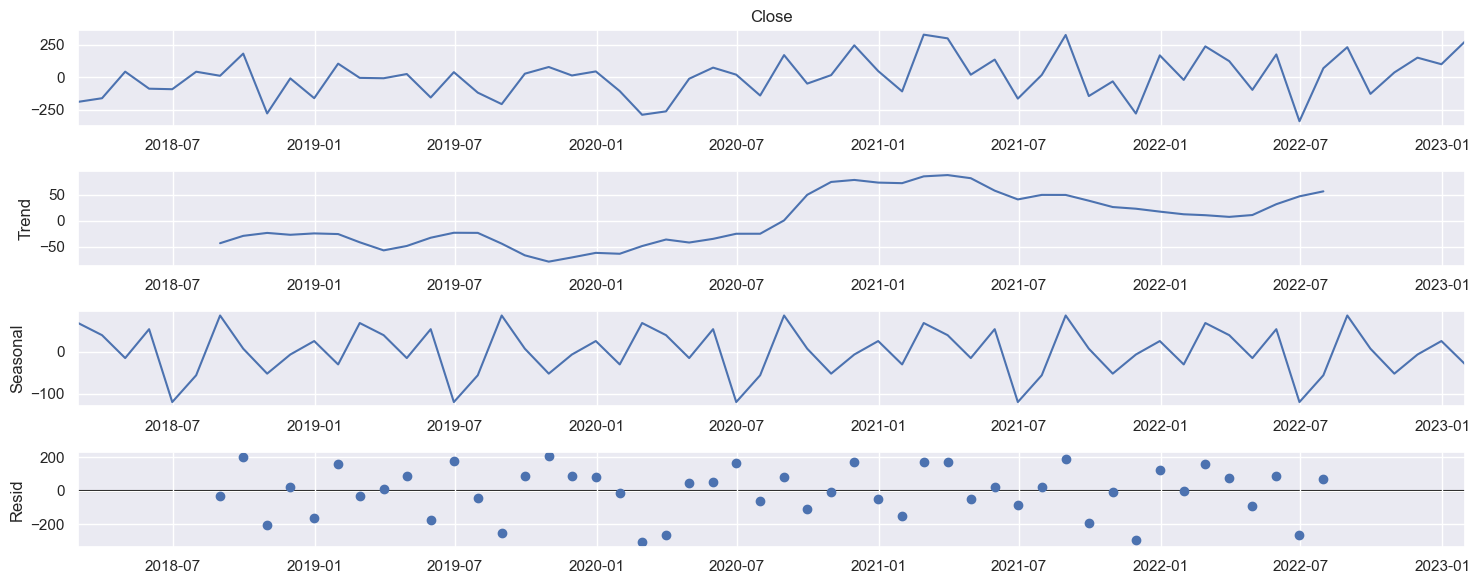

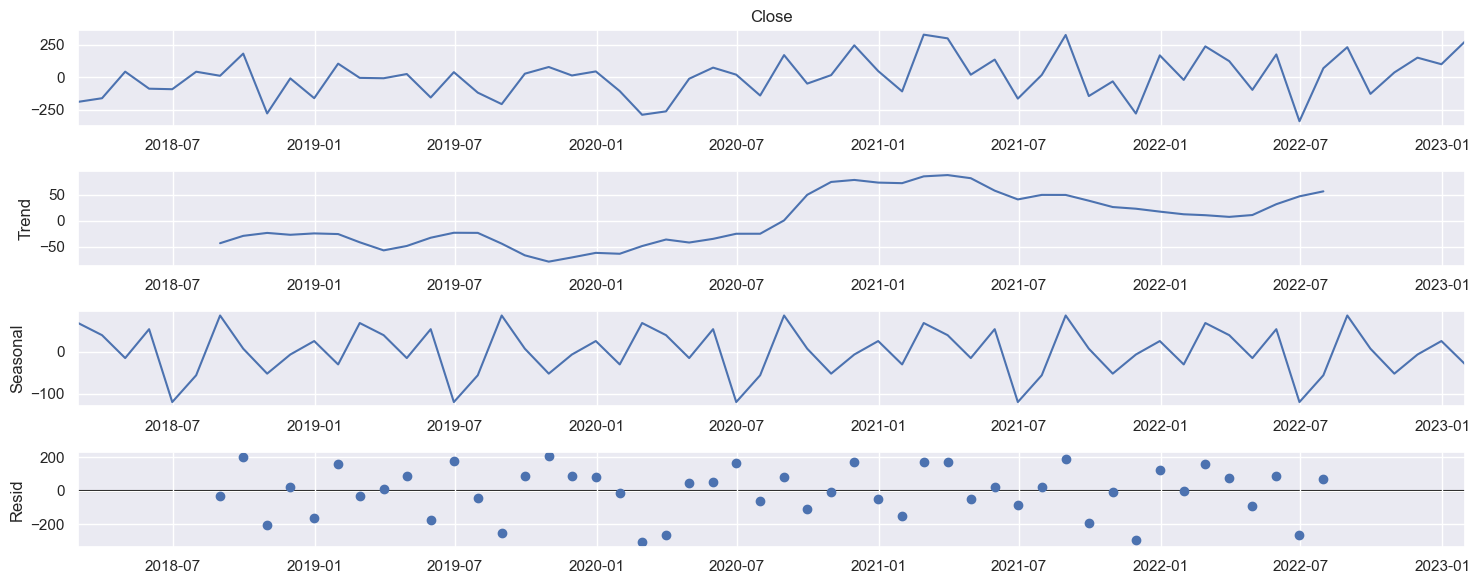

In [9]:
# 一次階差系列をプロットしてみる
result_diff = seasonal_decompose(data_diff, period=12, two_sided=True)
result_diff.plot()

なんとなく年毎の周期があるように見える

In [40]:
def selectparameter(DATA, s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    AICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA, order=param, seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.aic])
                AICs = np.append(AICs, results.aic)
            except:
                print('error')
                continue
    return parameters[np.argmin(AICs)]
best_params = selectparameter(data['Close'], 12)
print('BEST PARAMETER:', best_params)


c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmod

BEST PARAMETER: [(0, 1, 0), (1, 1, 0, 12), 648.0582075490302]


c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [87]:
train_data = data[:'2022-08']['Close']

In [88]:
sarima_model = sm.tsa.SARIMAX(train_data, order=(1,0,1),enforce_invertibility=False, enforce_stationarity=False)
result = sarima_model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                   56
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -349.830
Date:                Thu, 19 Jan 2023   AIC                            705.659
Time:                        21:57:10   BIC                            711.626
Sample:                    01-31-2018   HQIC                           707.960
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9950      0.012     80.214      0.000       0.971       1.019
ma.L1         -0.0622      0.141     -0.441      0.659      -0.339       0.214
sigma2       2.48e+04   5290.137      4.688      0.000    1.44e+04    3.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.98   Prob(JB):                         0.88
Heteroskedasticity (H):               2.57   Skew:                             0.04
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
best_pred = result.predict(start='2021-01', end='2023-12')

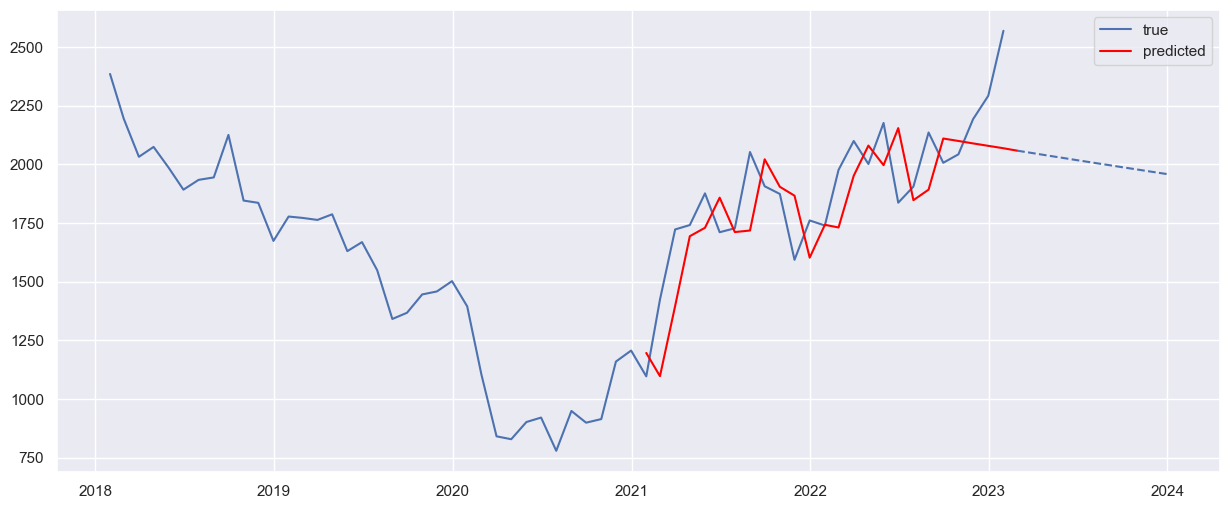

In [90]:
plt.plot(data['Close'], c='b', label='true')
plt.plot(result.predict(start='2021-01', end='2023-02'), c='red', label='predicted')
plt.plot(result.predict(start='2023-02', end='2023-12'), '--')
plt.legend()
plt.show()

学習として与えた期間の予測は